In [ ]:
import os
import shutil

from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import verify_str_arg
from torchvision.datasets.utils import download_and_extract_archive


def normalize_tin_val_folder_structure(path,
                                       images_folder='images',
                                       annotations_file='val_annotations.txt'):
    # Check if files/annotations are still there to see
    # if we already run reorganize the folder structure.
    images_folder = os.path.join(path, images_folder)
    annotations_file = os.path.join(path, annotations_file)

    # Exists
    if not os.path.exists(images_folder) \
       and not os.path.exists(annotations_file):
        if not os.listdir(path):
            raise RuntimeError('Validation folder is empty.')
        return

    # Parse the annotations
    with open(annotations_file) as f:
        for line in f:
            values = line.split()
            img = values[0]
            label = values[1]
            img_file = os.path.join(images_folder, values[0])
            label_folder = os.path.join(path, label)
            os.makedirs(label_folder, exist_ok=True)
            try:
                shutil.move(img_file, os.path.join(label_folder, img))
            except FileNotFoundError:
                continue

    os.sync()
    assert not os.listdir(images_folder)
    shutil.rmtree(images_folder)
    os.remove(annotations_file)
    os.sync()


class TinyImageNet(ImageFolder):
    """Dataset for TinyImageNet-200"""
    base_folder = 'tiny-imagenet-200'
    zip_md5 = '90528d7ca1a48142e341f4ef8d21d0de'
    splits = ('train', 'val')
    filename = 'tiny-imagenet-200.zip'
    url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'

    def __init__(self, root, split='train', download=False, **kwargs):
        self.data_root = os.path.expanduser(root)
        self.split = verify_str_arg(split, "split", self.splits)

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')
        super().__init__(self.split_folder, **kwargs)

    @property
    def dataset_folder(self):
        return os.path.join(self.data_root, self.base_folder)

    @property
    def split_folder(self):
        return os.path.join(self.dataset_folder, self.split)

    def _check_exists(self):
        return os.path.exists(self.split_folder)

    def extra_repr(self):
        return "Split: {split}".format(**self.__dict__)

    def download(self):
        if self._check_exists():
            return
        download_and_extract_archive(
            self.url, self.data_root, filename=self.filename,
            remove_finished=True, md5=self.zip_md5)
        assert 'val' in self.splits
        normalize_tin_val_folder_structure(
            os.path.join(self.dataset_folder, 'val'))

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'


In [ ]:
TRAINING_DATA_PATH="/content/train"
VALIDATION_DATA_PATH="/content/val"

In [ ]:
def data_loader(data_dir,
                batch_size,
                random_seed=42,
                valid_size=0.1,
                shuffle=True,
                test=False):

    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
#            normalize,
    ])

    if test:
        dataset = TinyImageNet(
            root=data_dir,
            split='val',
            download=True,
            transform=transform,
          )
        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle
        )

        return data_loader

    # load the dataset
    train_dataset = TinyImageNet(
            root=data_dir,
            download=True,
            transform=transform,
        )
    valid_dataset = TinyImageNet(
            root=data_dir,
            download=True,
            transform=transform,
        )
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(42)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)


# CIFAR10 dataset
train_loader, valid_loader = data_loader(data_dir=TRAINING_DATA_PATH,
                                         batch_size=64)

test_loader = data_loader(data_dir=VALIDATION_DATA_PATH,
                              batch_size=64,
                              test=True)

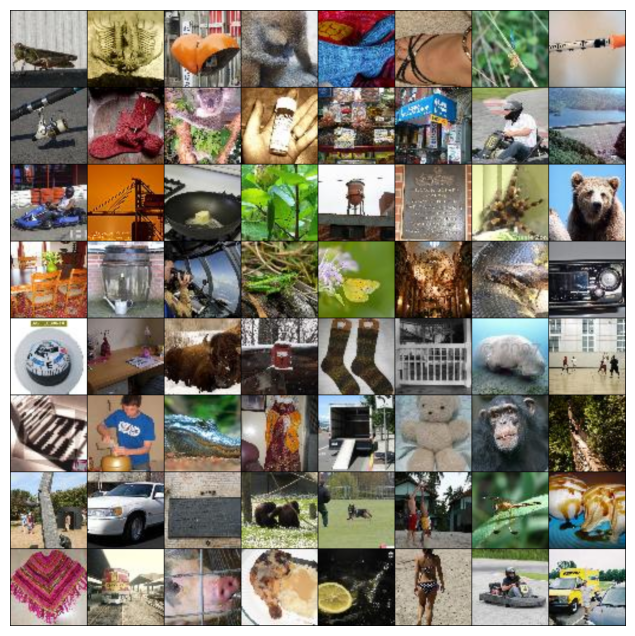

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
for images, _ in train_loader:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

In [ ]:
class GELU(nn.Module):
    def __init__(self, alpha=1.):
        super(GELU, self).__init__()
        self.alpha = alpha

    def forward(self, x):
        return x * 0.5 * (1 + torch.erf(x / np.sqrt(2.)))



class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        GELU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.gelu = GELU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.gelu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 1000):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.GELU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
num_classes = 1000
num_epochs = 20
batch_size = 16
learning_rate = 0.01

model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)

# Train the model
total_step = len(train_loader)

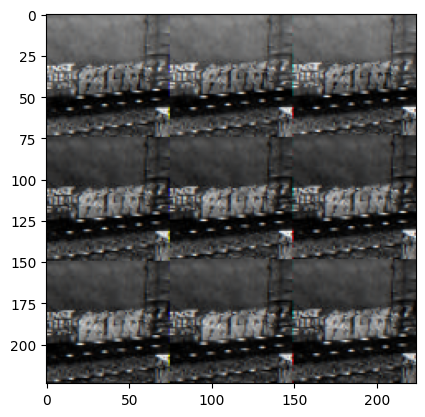

In [ ]:
import matplotlib.pyplot as plt

inputs, classes = next(iter(train_loader))
tensor_image = inputs[10]
tensor_image = tensor_image.view(tensor_image.shape[1], tensor_image.shape[2], tensor_image.shape[0])

plt.imshow(tensor_image)
plt.show()

In [ ]:
import gc
import sys
import time
import matplotlib.pyplot as plt

total_step = len(train_loader)
losses = []

for epoch in range(num_epochs):
    start_time = time.time()
    total_items = len(train_loader)
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        elapsed_time = time.time() - start_time
        estimated_remaining_time_seconds = (elapsed_time / (i + 1)) * (
            total_items - (i + 1)
        )
        losses.append(loss.item())
        estimated_remaining_time_hours = estimated_remaining_time_seconds / 3600

        print(
            "{}/{}  - {} % - {:.2f} hours".format(
                i,
                total_items,
                ((i + 1) / total_items) * 100,
                estimated_remaining_time_hours,
            ),
            end="\n",
        )
        sys.stdout.flush()
        gc.collect()

    print("Epoch [{}/{}], Loss: {:.4f}".format(epoch + 1, num_epochs, loss.item()))

# Validation
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print(
        "Accuracy of the network on the {} validation images: {} %".format(
            5000, 100 * correct / total
        )
    )
plt.plot(range(epochs), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()
plt.savefig('/content/foo.png', bbox_inches='tight')

import torch
torch.save(model, "./model.pt")

Streaming output truncated to the last 5000 lines.
962/1407  - 68.44349680170576 % - 0.08 hours
963/1407  - 68.51457000710732 % - 0.08 hours
964/1407  - 68.58564321250888 % - 0.08 hours
965/1407  - 68.65671641791045 % - 0.08 hours
966/1407  - 68.727789623312 % - 0.08 hours
967/1407  - 68.79886282871357 % - 0.08 hours
968/1407  - 68.86993603411514 % - 0.08 hours
969/1407  - 68.9410092395167 % - 0.08 hours
970/1407  - 69.01208244491826 % - 0.08 hours
971/1407  - 69.08315565031982 % - 0.08 hours
972/1407  - 69.15422885572139 % - 0.08 hours
973/1407  - 69.22530206112296 % - 0.08 hours
974/1407  - 69.29637526652452 % - 0.08 hours
975/1407  - 69.36744847192608 % - 0.08 hours
976/1407  - 69.43852167732764 % - 0.08 hours
977/1407  - 69.5095948827292 % - 0.08 hours
978/1407  - 69.58066808813076 % - 0.08 hours
979/1407  - 69.65174129353234 % - 0.08 hours
980/1407  - 69.7228144989339 % - 0.08 hours
981/1407  - 69.79388770433546 % - 0.08 hours
982/1407  - 69.86496090973702 % - 0.08 hours
983/1407 

In [ ]:
!pip install onnx
!pip install torch
!pip install onnxscript

In [ ]:
import torch.onnx

batch_size=1
modelx = ResNet(ResidualBlock, [3, 4, 6, 3])
x = torch.randn(1, 3, 224, 224)
onnx_program = torch.onnx.dynamo_export(modelx, x)
torch.onnx.export(onnx_program, x, "model.onnx")

In [ ]:
import torch
import torchvision.models as models
modelx = models.resnet50(pretrained=True)
x = torch.randn(1, 3, 224, 224)
onnx_program = torch.onnx.dynamo_export(modelx, x)
torch.onnx.export(onnx_program, x, "model.onnx")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.backends.cudnn as cudnn
import torch.utils.data


def create():
    model = torch.load("/content/model.pt").to('cpu')
    dummy_input = torch.autograd.Variable(torch.randn(1, 3, 224, 224))
    input_names = [ "data" ]
    output_names = [ "output" ]
    torch.onnx.export(model, dummy_input, 'resnet.onnx', input_names=input_names, output_names=output_names)

create()

In [ ]:
num_classes = 1000
num_epochs = 20
batch_size = 16
learning_rate = 0.01

model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)

# Train the model
total_step = len(train_loader)

In [ ]:
onnx_program.save(f"/content/my_image_classifier.onnx")

In [ ]:
for i, (images, labels) in enumerate(train_loader):
  print(labels)


Streaming output truncated to the last 5000 lines.
        143,  15, 169, 109,   0, 132,  60,  60, 169,  14, 193, 192, 148, 169,
         25,  33,   8,  34,  25, 136,  15,  91, 197, 117,  80, 199, 188,  19,
        170, 105, 185, 180, 105, 169,   9,  12])
tensor([191,  96, 168, 105,  49, 115, 184,  65, 150, 159, 160,  80, 158, 131,
         91, 187,  76, 138,  57,  55, 117, 178, 173,  66, 119,  18, 161, 177,
        132, 193, 166,  91,  66,  38, 167,  14,  45, 157,  57, 186,  97,  60,
        182, 111,  49,   7, 160, 134, 101,   5,  22, 148, 157, 116,  55,  36,
        189, 170,   6, 161,  96, 168, 199,  39])
tensor([ 79,  77, 147, 199, 100,  43, 151,  45, 104, 173,  85,  20, 177, 170,
        157, 101,  51, 122,  35,  71, 154, 160,  10,  19, 108, 110, 142, 177,
        101, 194,  55, 178,  99, 146,  70,   7,  30, 162, 101, 157,   1,  73,
         16, 121, 175,  47, 162, 124,  93,  10, 153,  33, 140,  97, 173, 134,
        106,  43, 191,   9, 196, 141, 142, 163])
tensor([ 26, 114,  98,